2.TPOT


In [6]:
import pandas as pd
# load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
# grab time series of electricity usage
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['electricity_usage'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['date_time', 'electricity_usage']].copy()
# set the index as and sort by date and time
df = df.set_index('date_time').sort_index()
# resample to hourly frequency
df_hour = df.resample('1H').mean()
# create shifted time series
df_hour['electricity_usage'] = df_hour['electricity_usage'].fillna(method='ffill')
df_hour['electricity_usage_1hr_lag'] = df_hour['electricity_usage'].shift()
df_hour['electricity_usage_2hr_lag'] = df_hour['electricity_usage'].shift(2)
df_hour['electricity_usage_3hr_lag'] = df_hour['electricity_usage'].shift(3)
df_hour['electricity_usage_4hr_lag'] = df_hour['electricity_usage'].shift(4)
df_hour['electricity_usage_5hr_lag'] = df_hour['electricity_usage'].shift(5)
df_hour['electricity_usage_6hr_lag'] = df_hour['electricity_usage'].shift(6)
df_hour['electricity_usage_7hr_lag'] = df_hour['electricity_usage'].shift(7)
df_hour['electricity_usage_8hr_lag'] = df_hour['electricity_usage'].shift(8)
# create month/seasonality as a feature
df_hour['month'] = df_hour.index.month
# drop missing data
df_hour = df_hour.dropna()
# split train test sets
sample_size = df_hour.shape[0] - 200
df_train = df_hour.iloc[:sample_size].copy()
df_test = df_hour.iloc[sample_size:].copy()

C:\Users\jv028u\AppData\Local\Temp\ipykernel_15112\2681619798.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
C:\Users\jv028u\AppData\Local\Temp\ipykernel_15112\2681619798.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df.resample('1H').mean()
C:\Users\jv028u\AppData\Local\Temp\ipykernel_15112\2681619798.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hour['electricity_usage'] = df_hour['electricity_usage'].fillna(method='ffill')


In [7]:
from tpot import TPOTRegressor

tpot_automl = TPOTRegressor(generations=10, population_size=10, 
                            verbosity=2, scoring='neg_mean_squared_error',   
                            max_time_mins=5, random_state = 666)

In [8]:
X_train = df_train.drop(columns='electricity_usage')
y_train = df_train['electricity_usage']

In [9]:
tpot_automl.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/10 [00:00<?, ?pipeline/s]


5.38 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RidgeCV(input_matrix)


TPOTRegressor(generations=10, max_time_mins=5, population_size=10,
              random_state=666, scoring='neg_mean_squared_error', verbosity=2)

In [10]:
# tpot_automl.export('tpot_best_model.py')

In [11]:
X_test = df_test.drop(columns='electricity_usage')
y_test = df_test['electricity_usage']

tpot_automl.score(X_test, y_test)

-0.4311993061438774

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = tpot_automl.predict(X_test)
mean_squared_error(y_test, y_pred)

0.4311993061438774

<Axes: xlabel='date_time'>

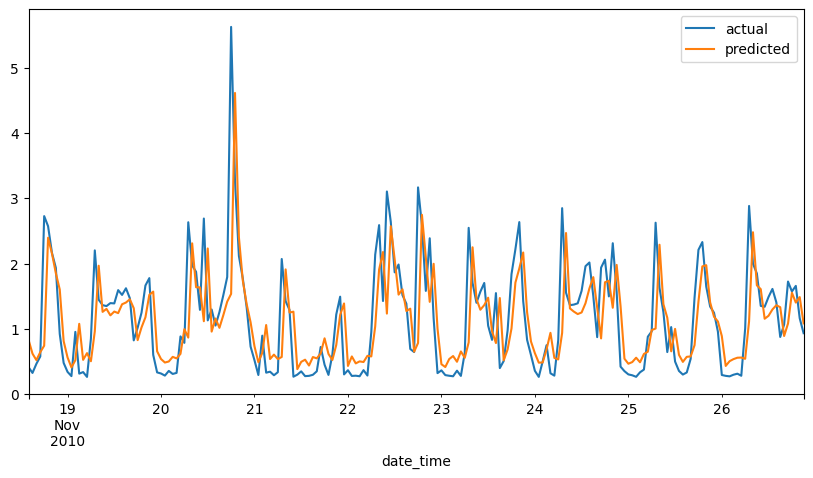

In [13]:
tpot_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred})
tpot_compare.plot(figsize=(10, 5))